# Summary:
This notebook will cover using BioBERT model to perform the classification task.

# Table of contents
* [4. BioBERT](#Part4_link)
<br >&nbsp;&nbsp;&nbsp;[4.1 Tokenize dataset and format input](#Part4.1_link)
<br >&nbsp;&nbsp;&nbsp;[4.2 Generate TensorDataset and DataLoader](#Part4.2_link)
<br >&nbsp;&nbsp;&nbsp;[4.3 Load pre-trained BioBERT](#Part4.3_link)
<br >&nbsp;&nbsp;&nbsp;[4.4 Train the classification model](#Part4.4_link)
<br >&nbsp;&nbsp;&nbsp;[4.5 Model evaluation](#Part4.5_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.5.1 BioBERT model_1: maxlen128_clip1](#Part4.5.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.5.2 BioBERT model_2: maxlen128_clip5](#Part4.5.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.5.3 BioBERT model_3: maxlen256_clip1](#Part4.5.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.5.4 BioBERT model_4: maxlen256_clip5](#Part4.5.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.5.5 BioBERT model_5: maxlen512_clip1](#Part4.5.5_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.5.6 BioBERT model_6: maxlen512_clip5](#Part4.5.6_link)
<br >&nbsp;&nbsp;&nbsp;[4.6 Make prediction](#Part4.6_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.6.1 BioBERT model_1: maxlen128_clip1 prediction](#Part4.6.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.6.2 BioBERT model_2: maxlen128_clip5 prediction](#Part4.6.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.6.3 BioBERT model_3: maxlen256_clip1 prediction](#Part4.6.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.6.4 BioBERT model_4: maxlen256_clip5 prediction](#Part4.6.4_link)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
import transformers
from transformers import BertTokenizer
from transformers import BertModel
from transformers import BertForSequenceClassification
from transformers import AdamW
from transformers import BertConfig
from transformers import get_linear_schedule_with_warmup

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
base_dir='/Volumes/Yuchen_Drive/Personalized_Medicine'
biobert_dir="/Volumes/Yuchen_Drive/bert"

In [3]:
train_text_df=pd.read_csv(os.path.join(base_dir, 'training_text'), sep='\|\|', header=None, skiprows=1, names=['ID', 'Text'])
train_text_df.head()

/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [4]:
train_variant_df=pd.read_csv(os.path.join(base_dir, 'training_variants'))
train_variant_df.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [5]:
train_df=pd.merge(train_text_df, train_variant_df, left_on='ID', right_on='ID')
train_df.head()

,ID,Text,Gene,Variation,Class
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4


In [6]:
train_df=train_df[train_df.Text.notnull()]
print(train_df.shape)

(3316, 5)


In [7]:
test_text_df=pd.read_csv(os.path.join(base_dir, 'test_text'), sep='\|\|', header=None, skiprows=1, names=['ID', 'Text'])
test_variant_df=pd.read_csv(os.path.join(base_dir, 'test_variants'))
test_df=pd.merge(test_text_df, test_variant_df, left_on='ID', right_on='ID')
print(test_df.shape)
test_df=test_df[test_df.Text.notnull()]
print(test_df.shape)

/Users/yuchenxie/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


(5668, 4)
(5667, 4)


<a id='Part4_link'></a>
# 4. BioBERT

**Reference**:
<br>https://github.com/dmis-lab/biobert
<br>https://mccormickml.com/2019/07/22/BERT-fine-tuning/
<br>https://academic.oup.com/bioinformatics/article/36/4/1234/5566506

<a id='Part4.1_link'></a>
## 4.1 Tokenize dataset and format input

In [8]:
tokenizer = BertTokenizer.from_pretrained(os.path.join(biobert_dir,'biobert_v1.1_pubmed'), do_lower_case=True)


In [9]:
def prepare_input_seq(input_seq,tokenizer, max_len):
    # here prepare the input sequence for the Bert model
    tokens0 = tokenizer.tokenize(str(input_seq))
    for j,t in enumerate(tokens0):
        if t in [".","?","!"]:
            tokens0[j] = t+" [SEP]"
    tokens = []
    for t in tokens0:
        tokens+=t.split()
    if tokens[-1]!='[SEP]':
        tokens = ['[CLS]'] + tokens + ['[SEP]']
    else:
        tokens = ['[CLS]'] + tokens
    
    if len(tokens)>max_len:
        padded_tokens = tokens[:max_len]
    else:
        padded_tokens = tokens +['[PAD]' for _ in range(max_len-len(tokens))]

    attn_mask=[1 if token != '[PAD]' else 0 for token in padded_tokens]

    #segment_ids = []
    #current_seg_id = 0
    #for token in padded_tokens:
    #    segment_ids += [current_seg_id]
    #    if token=="[SEP]":
    #        current_seg_id += 1

    indexed_tokens = tokenizer.convert_tokens_to_ids(padded_tokens)
    tokens_tensor = torch.tensor([indexed_tokens])
    #segments_tensors = torch.tensor([segment_ids])
    attn_mask = torch.tensor([attn_mask])

    return tokens_tensor,attn_mask

In [10]:
def sent_tokenizer(sents,tokenizer,max_len):
    id2sent = {j:sent for j,sent in enumerate(sents)}
    tokens_tensor_out=None
    attn_mask_out=None
    for j,sent in enumerate(sents):
        input_seq = sent
        tokens_tensor,attn_mask=prepare_input_seq(input_seq,tokenizer, max_len)
        if tokens_tensor_out is None:
            tokens_tensor_out=tokens_tensor
        else:
            tokens_tensor_out=torch.cat([tokens_tensor_out, tokens_tensor],axis=0)
        if attn_mask_out is None:
            attn_mask_out=attn_mask
        else:
            attn_mask_out=torch.cat([attn_mask_out, attn_mask],axis=0)
    return tokens_tensor_out, attn_mask_out


In [11]:
train_set,val_set=train_test_split(train_df,train_size=0.8,stratify=train_df.Class,random_state=8)

In [14]:
print("Number of samples in training set: {}".format(train_set.shape[0]))
print("Number of samples in validation set: {}".format(val_set.shape[0]))

Number of samples in training set: 2652
Number of samples in validation set: 664


In [16]:
train_tokens_tensor, train_attn_mask=sent_tokenizer(train_set.Text.values.tolist(),tokenizer,max_len=128)
val_tokens_tensor, val_attn_mask=sent_tokenizer(val_set.Text.values.tolist(),tokenizer,max_len=128)
test_tokens_tensor, test_attn_mask=sent_tokenizer(test_df.Text.values.tolist(),tokenizer,max_len=128)

In [18]:
print(train_tokens_tensor.shape)
print(train_attn_mask.shape)
print(val_tokens_tensor.shape)
print(val_attn_mask.shape)
print(test_tokens_tensor.shape)
print(test_attn_mask.shape)

torch.Size([2652, 128])
torch.Size([2652, 128])
torch.Size([664, 128])
torch.Size([664, 128])
torch.Size([5667, 128])
torch.Size([5667, 128])


<a id='Part4.2_link'></a>
## 4.2 Generate TensorDataset and DataLoader

In [19]:
train_data=TensorDataset(train_tokens_tensor,train_attn_mask,torch.tensor((train_set.Class-1).to_numpy(),dtype=torch.long))
val_data=TensorDataset(val_tokens_tensor,val_attn_mask,torch.tensor((val_set.Class-1).to_numpy(),dtype=torch.long))
test_data=TensorDataset(test_tokens_tensor,test_attn_mask)


In [20]:
BATCH_SIZE=32
## For max_len=256
#BATCH_SIZE=16
## For max_len=512
#BATCH_SIZE=8
train_loader=DataLoader(train_data,shuffle=True,batch_size=BATCH_SIZE)
val_loader=DataLoader(val_data,shuffle=True,batch_size=BATCH_SIZE)
test_loader=DataLoader(test_data,batch_size=BATCH_SIZE)

In [21]:
tokens_tensor,attn_mask,labels=next(iter(train_loader))
print("tokens_tensor: {}".format(tokens_tensor.shape))
print("attn_mask: {}".format(attn_mask.shape))
print('labels size: {}'.format(labels.shape))

tokens_tensor: torch.Size([32, 128])
attn_mask: torch.Size([32, 128])
labels size: torch.Size([32])


<a id='Part4.3_link'></a>
## 4.3 Load pre-trained BioBERT

In [40]:
model = BertForSequenceClassification.from_pretrained(os.path.join(biobert_dir,'biobert_v1.1_pubmed'),num_labels=9)


In [42]:
with torch.no_grad():
    loss,logits=model(tokens_tensor,
                 token_type_ids=None,
                 attention_mask=attn_mask,
                 labels=labels)

In [43]:
print(loss)
print(logits.shape)

tensor(2.1436)
torch.Size([32, 9])


<a id='Part4.4_link'></a>
## 4.4 Train the classification model

Here are some functions used in BioBERT model training, validation and testing.

In [52]:
def bert_train(n_epochs,model,train_loader,val_loader,optimizer,scheduler,device,save_path,batch_size,step_size,clip=1.0):
    step_dict={}
    model=model.to(device)
    step=1
    step_dict[1]={}
    valid_loss_min = np.Inf

    for epoch in np.arange(n_epochs):
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0
        dt = np.dtype(int)
        train_pred_array = np.array([], dtype = dt)
        train_y_array = np.array([], dtype = dt)
        val_pred_array = np.array([], dtype = dt)
        val_y_array = np.array([], dtype = dt)
        # Training
        model.train()
        for i,batch in enumerate(train_loader):
            optimizer.zero_grad()
            tokens_tensor,attn_mask,labels=batch[0].to(device),batch[1].to(device),batch[2].to(device)
            loss,logits=model(tokens_tensor,
                              token_type_ids=None,
                              attention_mask=attn_mask,
                              labels=labels)
            train_loss += loss.item()*tokens_tensor.shape[0]
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            scheduler.step()
            ## Update acc and pred values for the training process
            _, top_class = logits.topk(1,dim=1)
            equals = top_class == labels.view(*top_class.shape)
            train_acc += torch.mean(equals.type(torch.FloatTensor)).item()
            if device.type == 'cpu':
                train_pred_array = np.append(train_pred_array, torch.reshape(top_class, labels.shape).numpy())
                train_y_array = np.append(train_y_array, labels.numpy())
            else:
                train_pred_array = np.append(train_pred_array, torch.reshape(top_class.cpu(), labels.cpu().shape).numpy())
                train_y_array = np.append(train_y_array, labels.cpu().numpy())
            
            if (i+1)%step_size==0:
                ## validation
                with torch.no_grad():
                    model.eval()
                    for batch in val_loader:
                        tokens_tensor,attn_mask,labels=batch[0].to(device),batch[1].to(device),batch[2].to(device)
                        loss,logits=model(tokens_tensor,
                              token_type_ids=None,
                              attention_mask=attn_mask,
                              labels=labels)
                        ## Update acc, loss and pred values for the validation process
                        val_loss += loss.item()*tokens_tensor.shape[0]
                        _, top_class = logits.topk(1,dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        val_acc += torch.mean(equals.type(torch.FloatTensor)).item()
                        if device.type == 'cpu':
                            val_pred_array = np.append(val_pred_array, torch.reshape(top_class, labels.shape).numpy())
                            val_y_array = np.append(val_y_array, labels.numpy())
                        else:
                            val_pred_array = np.append(val_pred_array, torch.reshape(top_class.cpu(), labels.cpu().shape).numpy())
                            val_y_array = np.append(val_y_array, labels.cpu().numpy())
                    ### write training/validation loss/accuracy
                    step_dict[step]["Train_Loss"]=train_loss/(step_size*batch_size)
                    step_dict[step]["Train_Accuracy"]=train_acc/step_size
                    step_dict[step]["Val_Loss"]=val_loss/len(val_loader.sampler)
                    step_dict[step]["Val_Accuracy"]=val_acc/len(val_loader)
                    step_dict[step]["Train_kappa"]=cohen_kappa_score(train_y_array, train_pred_array)
                    step_dict[step]["Val_kappa"]=cohen_kappa_score(val_y_array, val_pred_array)

                    print("Step: {}.. ".format(step),
                          "Train Loss: {:.3f}.. ".format(step_dict[step]["Train_Loss"]),
                          "Train Accuracy: {:.3f}.. ".format(step_dict[step]["Train_Accuracy"]),
                          "Train cohen's kappa: {:.3f}.. ".format(step_dict[step]["Train_kappa"]),
                          "Validation Loss: {:.3f}.. ".format(step_dict[step]["Val_Loss"]),
                          "Validation Accuracy: {:.3f}.. ".format(step_dict[step]["Val_Accuracy"]),
                          "Validation cohen's kappa: {:.3f}.. ".format(step_dict[step]["Val_kappa"]))

                    ## save the model with the lowest val_loss and update valid_loss_min
                    if val_loss <= valid_loss_min:
                        print('Validation loss decreased -- Saving model -- \n')
                        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
                        model_to_save.save_pretrained(save_path)
                        #torch.save(model.state_dict(), save_path)
                        valid_loss_min = val_loss
                    
                    step+=1
                    step_dict[step]={}
                    train_loss = 0.0
                    train_acc = 0.0
                    val_loss = 0.0
                    val_acc = 0.0
                    dt = np.dtype(int)
                    train_pred_array = np.array([], dtype = dt)
                    train_y_array = np.array([], dtype = dt)
                    val_pred_array = np.array([], dtype = dt)
                    val_y_array = np.array([], dtype = dt)
        
    step_df=pd.DataFrame.from_dict(step_dict,orient="index")
    step_df["step"]=step_df.index
    return model,step_df

In [53]:
def bert_eval(val_loader, model, device, classes):
    model=model.to(device)
    # Initiate loss and accuracy values
    val_loss = 0.0
    val_acc = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    
    dt = np.dtype(int)
    true_label = np.array([], dtype = dt)
    pred_label = np.array([], dtype = dt)
    prob_array = np.array([])
    probs_array = np.arange(1,len(classes)+1).reshape(1,-1)
    
    with torch.no_grad():
        model.eval()
        for batch in val_loader:
            tokens_tensor,attn_mask,labels=batch[0].to(device),batch[1].to(device),batch[2].to(device)
            loss,logits=model(tokens_tensor,
                              token_type_ids=None,
                              attention_mask=attn_mask,
                              labels=labels)
            
            ## Update acc, loss and pred values for the validation process
            val_loss += loss.item()*tokens_tensor.shape[0]
            top_probs, preds = logits.topk(1,dim=1)
            equals = preds == labels.view(*preds.shape)
            correct = np.squeeze(equals)
            val_acc += torch.mean(equals.type(torch.FloatTensor)).item()
                        
            for i in range(tokens_tensor.shape[0]):
                label = labels[i].item()
                class_correct[label] += correct[i].item()
                class_total[label] += 1
    
            if device.type == 'cpu':
                true_label = np.append(true_label, labels)
                pred_label = np.append(pred_label, preds)
                prob_array = np.append(prob_array, top_probs)
                probs_array = np.concatenate((probs_array, logits))
      
            else:
                true_label = np.append(true_label, labels.cpu())
                pred_label = np.append(pred_label, preds.cpu())
                prob_array = np.append(prob_array, top_probs.cpu())
                probs_array = np.concatenate((probs_array, logits.cpu()))
    
    val_loss = val_loss/len(val_loader.sampler)
    val_acc = val_acc/len(val_loader)
    print('Test Loss: {:.6f}\n'.format(val_loss))
    print('Test Accuracy (Overall): {:.3f}%  ({}/{})\n'.format(np.sum(class_correct)/np.sum(class_total)*100, np.sum(class_correct), np.sum(class_total)))
    
    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of {}: {:.3f}% ({}/{})'.format(classes[i], class_correct[i]/class_total[i]*100,class_correct[i], class_total[i]))
        else:
            print('Test Accuracy of {}: N/A'.format(classes[i]))
    summary_df = pd.DataFrame({'category': classes, 'correct': class_correct, 'total': class_total})
    pred_df = pd.DataFrame({'true_label': true_label, 'prediction': pred_label, 'prob': prob_array})
    probs_df = pd.DataFrame(probs_array[1:], columns = ['class_{}'.format(i) for i in range(1,10)])
    pred_df = pd.merge(pred_df, probs_df, left_index=True, right_index=True)
    return summary_df, pred_df
    

In [108]:
def bert_test(test_loader, model, device, classes):
    model=model.to(device)
    dt = np.dtype(int)
    pred_label = np.array([], dtype = dt)
    prob_array = np.array([])
    probs_array = np.arange(1,len(classes)+1).reshape(1,-1)
    
    with torch.no_grad():
        model.eval()
        for batch in test_loader:
            tokens_tensor,attn_mask=batch[0].to(device),batch[1].to(device)
            output=model(tokens_tensor,
                              token_type_ids=None,
                              attention_mask=attn_mask)
            
            logits=output[0]
            top_probs, preds = logits.topk(1,dim=1)
                        
            if device.type == 'cpu':
                pred_label = np.append(pred_label, preds)
                prob_array = np.append(prob_array, top_probs)
                probs_array = np.concatenate((probs_array, logits))
      
            else:
                pred_label = np.append(pred_label, preds.cpu())
                prob_array = np.append(prob_array, top_probs.cpu())
                probs_array = np.concatenate((probs_array, logits.cpu()))
    
    pred_df = pd.DataFrame({'prediction': pred_label, 'prob': prob_array})
    probs_df = pd.DataFrame(probs_array[1:], columns = ['class_{}'.format(i) for i in range(1,10)])
    pred_df = pd.merge(pred_df, probs_df, left_index=True, right_index=True)
    return pred_df
    

In [36]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = BertForSequenceClassification.from_pretrained(os.path.join(biobert_dir,'biobert_v1.1_pubmed'),num_labels=9)

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

n_epochs=10
total_steps = len(train_loader)*n_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Here three max_len values and two clip values are used. 
<br>The corresponding batch_size/ step_size are listed as follows:

| max_len  | batch_size | step_size |
| ---------| ---------| ---------|
| 128  | 32  | 20 |
| 256  | 16  | 40 |
| 512  | 8   | 80 |

In [ ]:
save_path=os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen128_epoch10_batch32_step20_clip1")
model,step_df=bert_train(n_epochs,model,train_loader,val_loader,optimizer,scheduler,device,save_path,batch_size=BATCH_SIZE,step_size=20,clip=1.0)
step_df.to_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen128_epoch10_batch32_step20_clip1.csv"),index=False)

In [ ]:
save_path=os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen128_epoch10_batch32_step20_clip5")
model,step_df=bert_train(n_epochs,model,train_loader,val_loader,optimizer,scheduler,device,save_path,batch_size=BATCH_SIZE,step_size=20,clip=5.0)
step_df.to_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen128_epoch10_batch32_step20_clip5.csv"),index=False)

In [ ]:
save_path=os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen256_epoch10_batch16_step40_clip1")
model,step_df=bert_train(n_epochs,model,train_loader,val_loader,optimizer,scheduler,device,save_path,batch_size=BATCH_SIZE,step_size=40,clip=1.0)
step_df.to_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen256_epoch10_batch16_step40_clip1.csv"),index=False)

In [ ]:
save_path=os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen256_epoch10_batch16_step40_clip5")
model,step_df=bert_train(n_epochs,model,train_loader,val_loader,optimizer,scheduler,device,save_path,batch_size=BATCH_SIZE,step_size=40,clip=5.0)
step_df.to_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen256_epoch10_batch16_step40_clip5.csv"),index=False)

In [ ]:
save_path=os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen512_epoch10_batch8_step80_clip1")
model,step_df=bert_train(n_epochs,model,train_loader,val_loader,optimizer,scheduler,device,save_path,batch_size=BATCH_SIZE,step_size=80,clip=1.0)
step_df.to_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen512_epoch10_batch8_step80_clip1.csv"),index=False)

In [ ]:
save_path=os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen512_epoch10_batch8_step80_clip5")
model,step_df=bert_train(n_epochs,model,train_loader,val_loader,optimizer,scheduler,device,save_path,batch_size=BATCH_SIZE,step_size=80,clip=5.0)
step_df.to_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen512_epoch10_batch8_step80_clip5.csv"),index=False)

<a id='Part4.5_link'></a>
## 4.5 Model evaluation

Here are some functions used in model evaluation.

In [21]:
def plot_training_validation_curve(step_df,title=""):
    fig=plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    plt.plot(step_df.step,step_df.Train_Loss,label="Training loss")
    plt.plot(step_df.step,step_df.Val_Loss,label="Validation loss")
    plt.xlabel('Step', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.title('Training and Validation Loss', fontsize=16)

    plt.subplot(1,3,2)
    plt.plot(step_df.step,step_df.Train_Accuracy,label="Training Accuracy")
    plt.plot(step_df.step,step_df.Val_Accuracy,label="Validation Accuracy")
    plt.xlabel('Step', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.title('Training and Validation Accuracy', fontsize=16)

    plt.subplot(1,3,3)
    plt.plot(step_df.step,step_df.Train_kappa,label="Training cohen's kappa")
    plt.plot(step_df.step,step_df.Val_kappa,label="Validation cohen's kappa")
    plt.xlabel('Step', fontsize=12)
    plt.ylabel("cohen's kappa", fontsize=12)
    plt.legend()
    plt.title("Training and Validation cohen's kappa", fontsize=16)
    plt.tight_layout()
    
    fig.suptitle(title,fontsize=20)
    plt.tight_layout()
    fig.subplots_adjust(top=0.86)

In [61]:
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar(shrink=0.8)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12, fontweight='bold')
    plt.yticks(tick_marks, classes, fontsize=12, fontweight='bold')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:d} \n({:.2f}%)'.format(cm[i, j], cm[i,j]/cm.sum()*100), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.tight_layout()

In [67]:
def plot_acc_bar(cm,total_acc):
    acc=[cm[i][i] for i in range(len(classes))]
    acc_freq=acc/cm.sum(axis=1)
    fig = plt.figure(figsize = (20,8))
    ax = fig.add_subplot(1,1,1)
    width = 0.75 # the width of the bars 
    ind = np.arange(len(classes))  # the x locations for the groups
    ax.bar(ind, np.round(acc_freq*100,2), width, edgecolor='black', color = sns.color_palette('hls', len(classes)))
    plt.xticks(ind, labels = classes, fontsize=18, fontweight='bold', rotation=45)
    plt.yticks(fontsize=16)
    plt.xlabel('Category', fontsize=18)
    plt.ylabel('Accuracy%', fontsize=18)
    for i, v in enumerate(np.round(acc_freq*100,2)):
        ax.text(i-0.25, v + 1, str(np.round(v,2))+'%', fontweight='bold', fontsize=18)
        ax.plot([-0.5, 8.5], [total_acc, total_acc], "k--", linewidth=2)
    ax.text(8.5, total_acc, 'Avg:\n'+str(total_acc)+'%', fontweight='bold', fontsize=18)

In [72]:
def plot_ROC_curve(pred_df):
    probas=np.array(pred_df.drop(['true_label','prediction','prob'],axis=1))

    fpr = dict()
    tpr = dict()
    auc_list = []
    label_to_class_dict = {i:l for i,l in enumerate(classes)}
    for i in np.arange(len(classes)):
        true_label_array = (pred_df.true_label.values == i).astype(np.uint8)
        probs = probas[:,i]
        fpr[i], tpr[i], _ = roc_curve(true_label_array, probs)
        auc_value = auc(fpr[i], tpr[i])
        auc_list.append(auc_value)

    palette=sns.color_palette('hls',len(classes))
    for i in np.arange(len(classes)):
        plt.plot(fpr[i], tpr[i], color = palette[i], label='{} (area = {:.2f})'.format(classes[i], auc_list[i]))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

<a id='Part4.5.1_link'></a>
### 4.5.1 BioBERT model_1: maxlen128_clip1

In [49]:
model = BertForSequenceClassification.from_pretrained(os.path.join(base_dir,'models_bert/Personalized_Medicine_biobert_maxlen128_epoch10_batch32_step20_clip1'),num_labels=9)


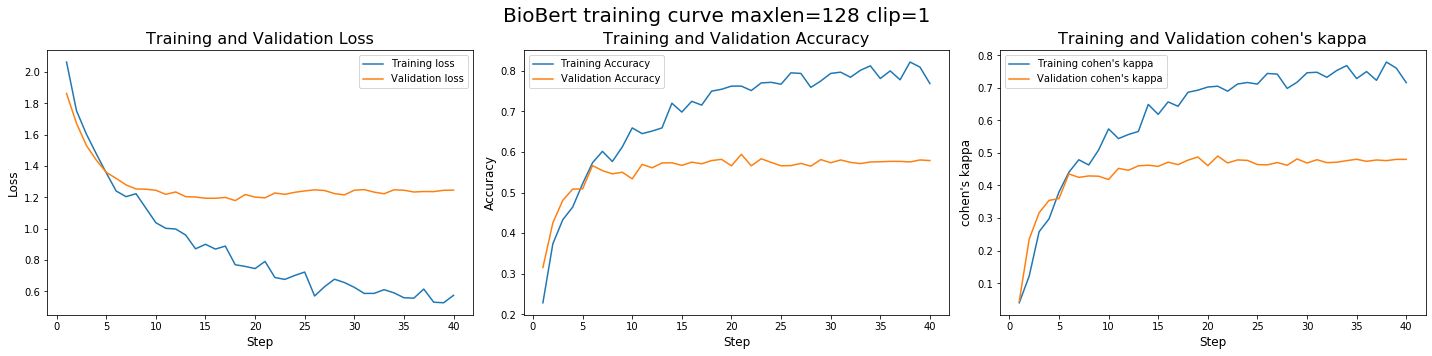

In [51]:
step_df_maxlen128_clip1=pd.read_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen128_epoch10_batch32_step20_clip1.csv"))
plot_training_validation_curve(step_df_maxlen128_clip1,title="BioBert training curve maxlen=128 clip=1")

In [59]:
classes = np.array(['Class_'+str(i+1) for i in np.arange(9)])
summary_df,pred_df=bert_eval(val_loader, model, device, classes)

Test Loss: 1.178349

Test Accuracy (Overall): 57.982%  (385.0/664.0)

Test Accuracy of Class_1: 61.062% (69.0/113.0)
Test Accuracy of Class_2: 56.044% (51.0/91.0)
Test Accuracy of Class_3: 0.000% (0.0/18.0)
Test Accuracy of Class_4: 65.693% (90.0/137.0)
Test Accuracy of Class_5: 20.833% (10.0/48.0)
Test Accuracy of Class_6: 65.455% (36.0/55.0)
Test Accuracy of Class_7: 67.016% (128.0/191.0)
Test Accuracy of Class_8: 0.000% (0.0/4.0)
Test Accuracy of Class_9: 14.286% (1.0/7.0)


In [60]:
summary_df.to_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen128_epoch10_batch32_step20_clip1_summary_df.csv"),index=False)
pred_df.to_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen128_epoch10_batch32_step20_clip1_pred_df.csv"),index=False)

#summary_df=pd.read_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen128_epoch10_batch32_step20_clip1_summary_df.csv"))
#pred_df=pd.read_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen128_epoch10_batch32_step20_clip1_pred_df.csv"))


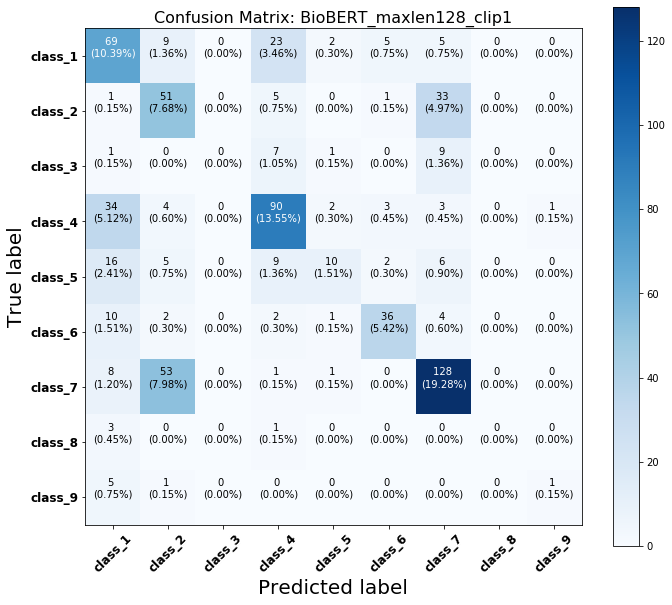

In [66]:
cm = confusion_matrix(pred_df.true_label, pred_df.prediction)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix: BioBERT_maxlen128_clip1', cmap=plt.cm.Blues)

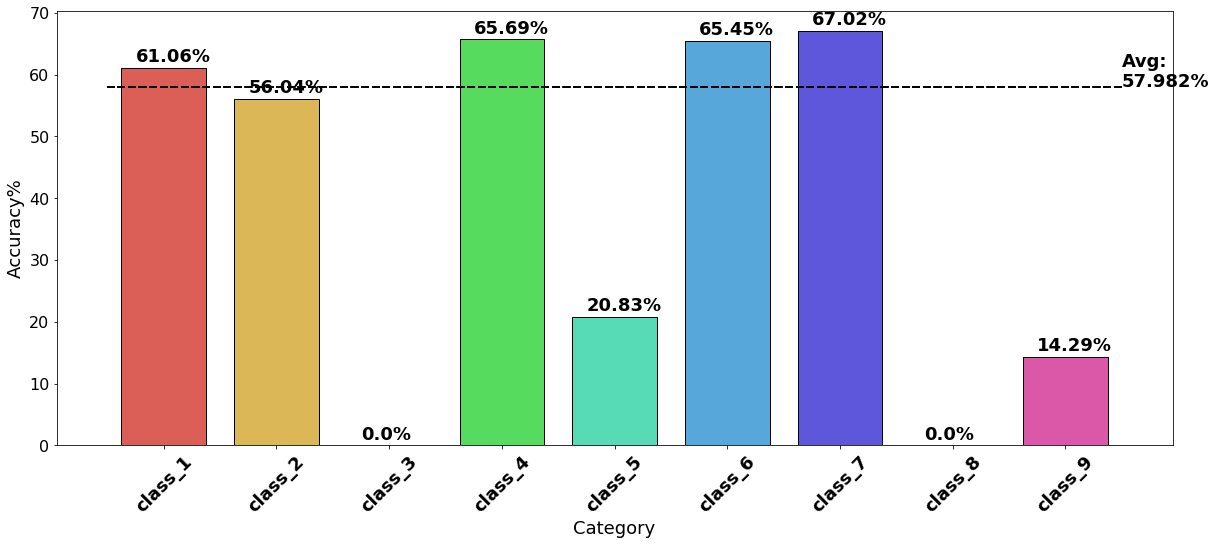

In [68]:
plot_acc_bar(cm,total_acc=57.982)

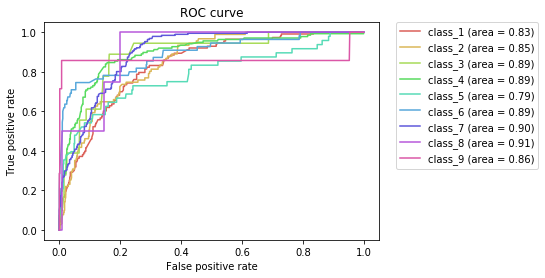

In [73]:
plot_ROC_curve(pred_df)

<a id='Part4.5.2_link'></a>
### 4.5.2 BioBERT model_2: maxlen128_clip5

In [99]:
model = BertForSequenceClassification.from_pretrained(os.path.join(base_dir,'models_bert/Personalized_Medicine_biobert_maxlen128_epoch10_batch32_step20_clip5'),num_labels=9)


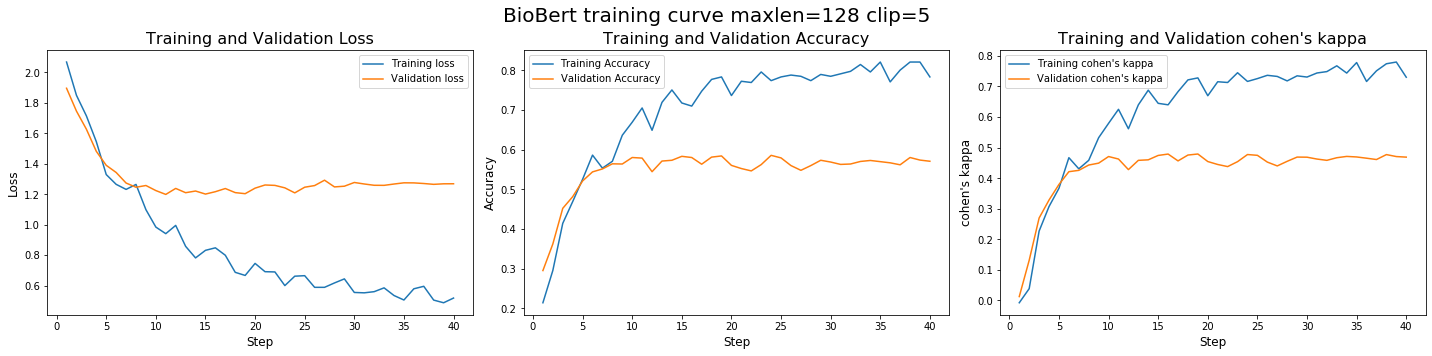

In [100]:
step_df_maxlen128_clip1=pd.read_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen128_epoch10_batch32_step20_clip5.csv"))
plot_training_validation_curve(step_df_maxlen128_clip1,title="BioBert training curve maxlen=128 clip=5")

In [101]:
classes = np.array(['Class_'+str(i+1) for i in np.arange(9)])
summary_df,pred_df=bert_eval(val_loader, model, device, classes)

Test Loss: 1.198257

Test Accuracy (Overall): 57.831%  (384.0/664.0)

Test Accuracy of Class_1: 46.018% (52.0/113.0)
Test Accuracy of Class_2: 24.176% (22.0/91.0)
Test Accuracy of Class_3: 0.000% (0.0/18.0)
Test Accuracy of Class_4: 69.343% (95.0/137.0)
Test Accuracy of Class_5: 27.083% (13.0/48.0)
Test Accuracy of Class_6: 65.455% (36.0/55.0)
Test Accuracy of Class_7: 86.911% (166.0/191.0)
Test Accuracy of Class_8: 0.000% (0.0/4.0)
Test Accuracy of Class_9: 0.000% (0.0/7.0)


In [102]:
summary_df.to_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen128_epoch10_batch32_step20_clip5_summary_df.csv"),index=False)
pred_df.to_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen128_epoch10_batch32_step20_clip5_pred_df.csv"),index=False)

#summary_df=pd.read_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen128_epoch10_batch32_step20_clip5_summary_df.csv"))
#pred_df=pd.read_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen128_epoch10_batch32_step20_clip5_pred_df.csv"))


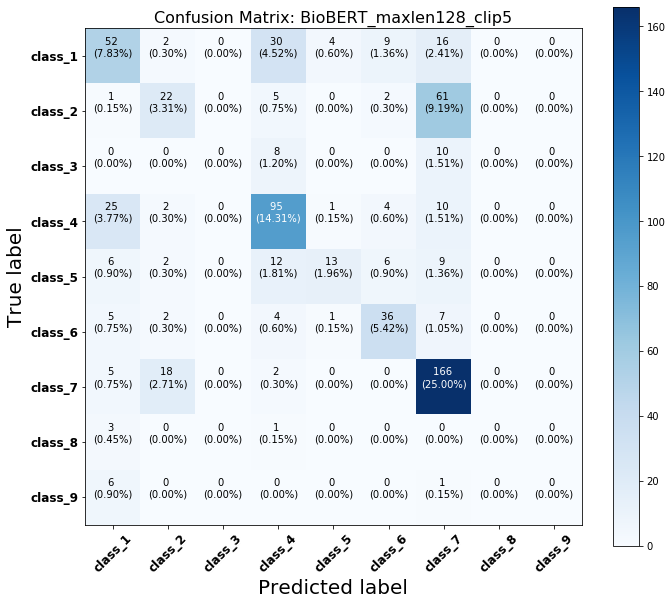

In [103]:
cm = confusion_matrix(pred_df.true_label, pred_df.prediction)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix: BioBERT_maxlen128_clip5', cmap=plt.cm.Blues)

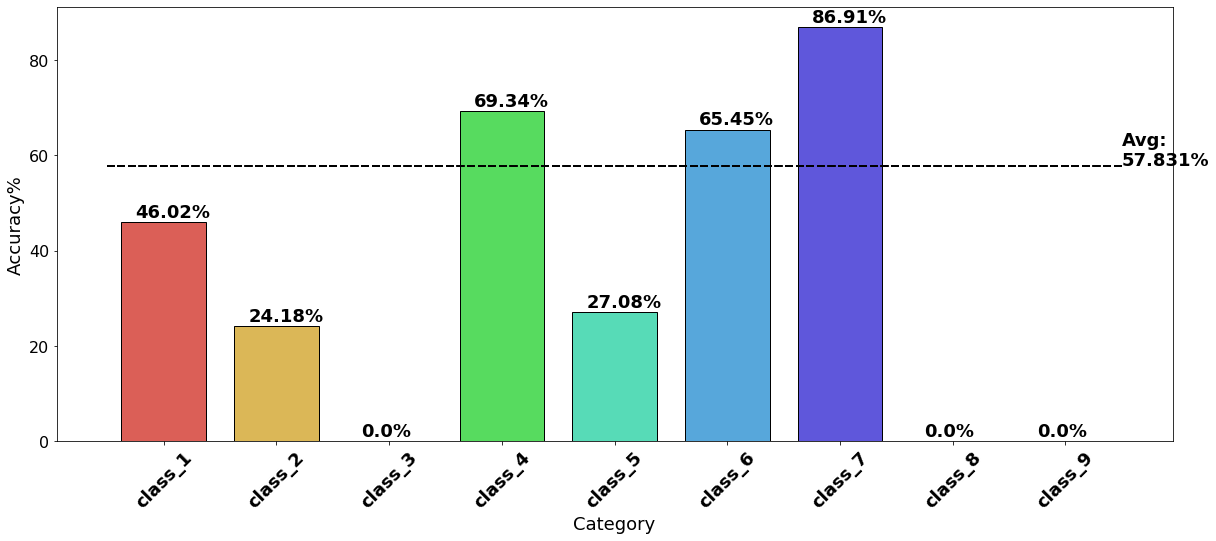

In [104]:
plot_acc_bar(cm,total_acc=57.831)

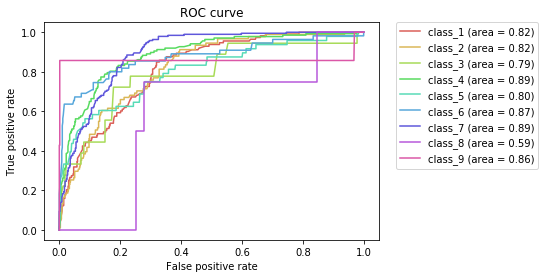

In [105]:
plot_ROC_curve(pred_df)

<a id='Part4.5.3_link'></a>
### 4.5.3 BioBERT model_3: maxlen256_clip1

In [138]:
model = BertForSequenceClassification.from_pretrained(os.path.join(base_dir,'models_bert/Personalized_Medicine_biobert_maxlen256_epoch10_batch16_step40_clip1'),num_labels=9)


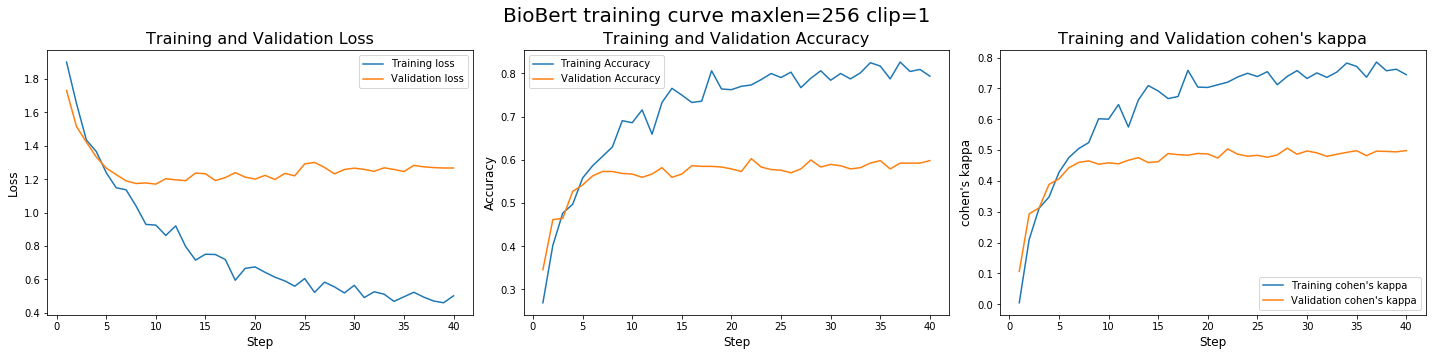

In [139]:
step_df_maxlen256_clip1=pd.read_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen256_epoch10_batch16_step40_clip1.csv"))
plot_training_validation_curve(step_df_maxlen256_clip1,title="BioBert training curve maxlen=256 clip=1")

In [140]:
classes = np.array(['Class_'+str(i+1) for i in np.arange(9)])
summary_df,pred_df=bert_eval(val_loader, model, device, classes)

Test Loss: 1.170472

Test Accuracy (Overall): 57.078%  (379.0/664.0)

Test Accuracy of Class_1: 55.752% (63.0/113.0)
Test Accuracy of Class_2: 28.571% (26.0/91.0)
Test Accuracy of Class_3: 5.556% (1.0/18.0)
Test Accuracy of Class_4: 59.854% (82.0/137.0)
Test Accuracy of Class_5: 18.750% (9.0/48.0)
Test Accuracy of Class_6: 67.273% (37.0/55.0)
Test Accuracy of Class_7: 82.723% (158.0/191.0)
Test Accuracy of Class_8: 0.000% (0.0/4.0)
Test Accuracy of Class_9: 42.857% (3.0/7.0)


In [141]:
summary_df.to_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen256_epoch10_batch16_step40_clip1_summary_df.csv"),index=False)
pred_df.to_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen256_epoch10_batch16_step40_clip1_pred_df.csv"),index=False)

#summary_df=pd.read_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen256_epoch10_batch16_step40_clip1_summary_df.csv"))
#pred_df=pd.read_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen256_epoch10_batch16_step40_clip1_pred_df.csv"))


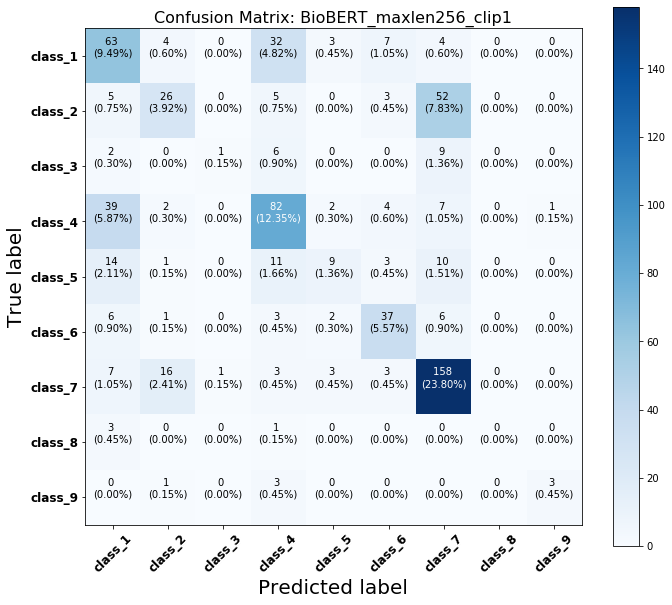

In [142]:
cm = confusion_matrix(pred_df.true_label, pred_df.prediction)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix: BioBERT_maxlen256_clip1', cmap=plt.cm.Blues)

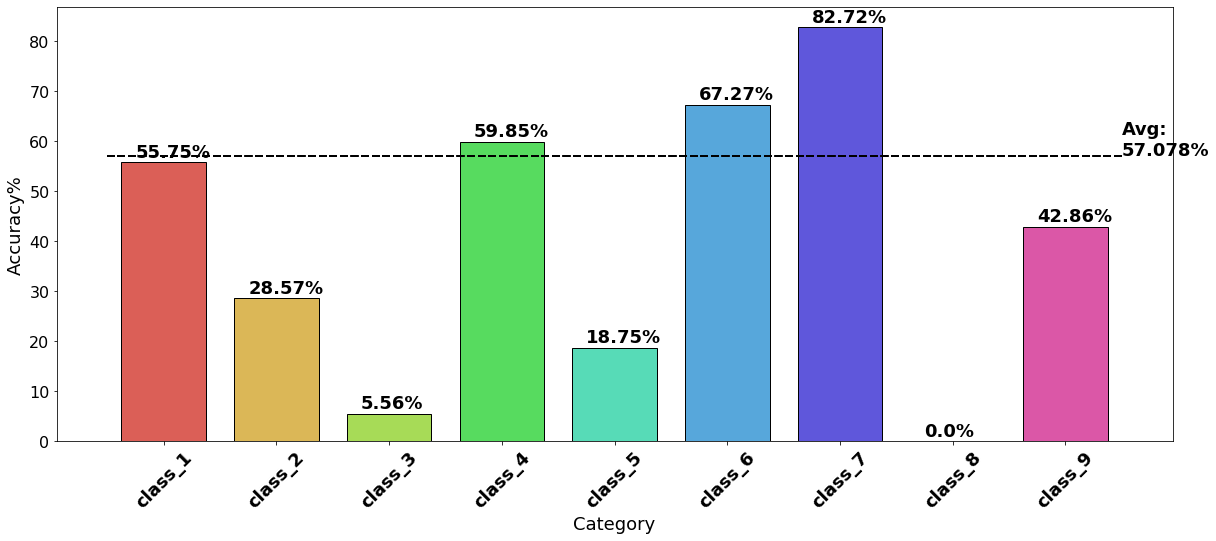

In [143]:
plot_acc_bar(cm,total_acc=57.078)

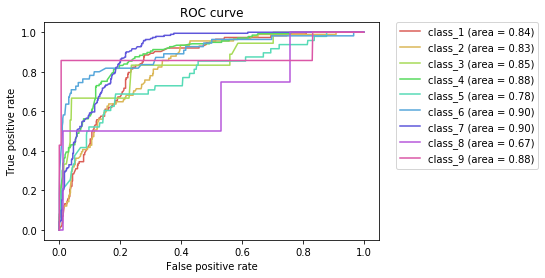

In [144]:
plot_ROC_curve(pred_df)

<a id='Part4.5.4_link'></a>
### 4.5.4 BioBERT model_4: maxlen256_clip5

In [145]:
model = BertForSequenceClassification.from_pretrained(os.path.join(base_dir,'models_bert/Personalized_Medicine_biobert_maxlen256_epoch10_batch16_step40_clip5'),num_labels=9)


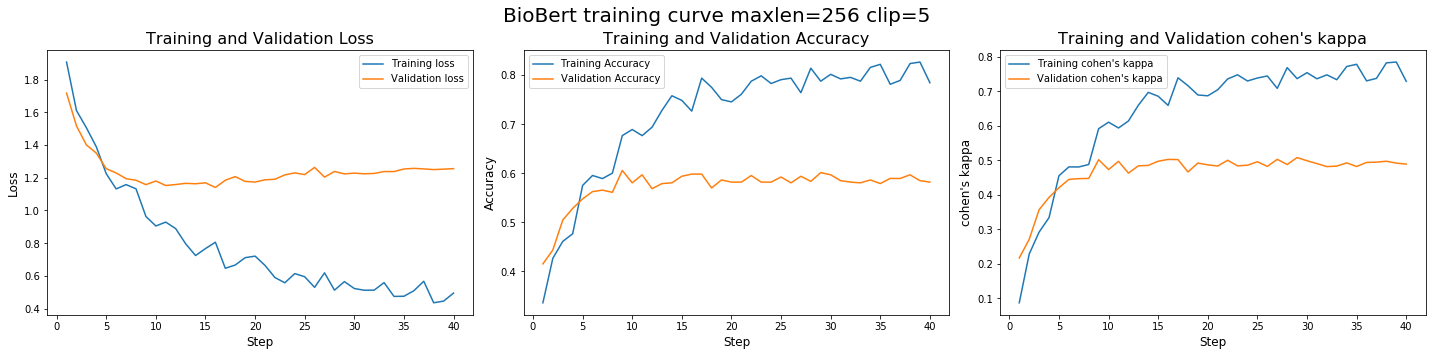

In [146]:
step_df_maxlen256_clip5=pd.read_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen256_epoch10_batch16_step40_clip5.csv"))
plot_training_validation_curve(step_df_maxlen256_clip5,title="BioBert training curve maxlen=256 clip=5")

In [147]:
classes = np.array(['Class_'+str(i+1) for i in np.arange(9)])
summary_df,pred_df=bert_eval(val_loader, model, device, classes)

Test Loss: 1.140353

Test Accuracy (Overall): 59.940%  (398.0/664.0)

Test Accuracy of Class_1: 57.522% (65.0/113.0)
Test Accuracy of Class_2: 52.747% (48.0/91.0)
Test Accuracy of Class_3: 0.000% (0.0/18.0)
Test Accuracy of Class_4: 59.124% (81.0/137.0)
Test Accuracy of Class_5: 33.333% (16.0/48.0)
Test Accuracy of Class_6: 67.273% (37.0/55.0)
Test Accuracy of Class_7: 75.916% (145.0/191.0)
Test Accuracy of Class_8: 0.000% (0.0/4.0)
Test Accuracy of Class_9: 85.714% (6.0/7.0)


In [148]:
summary_df.to_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen256_epoch10_batch16_step40_clip5_summary_df.csv"),index=False)
pred_df.to_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen256_epoch10_batch16_step40_clip5_pred_df.csv"),index=False)

#summary_df=pd.read_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen256_epoch10_batch16_step40_clip5_summary_df.csv"))
#pred_df=pd.read_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen256_epoch10_batch16_step40_clip5_pred_df.csv"))


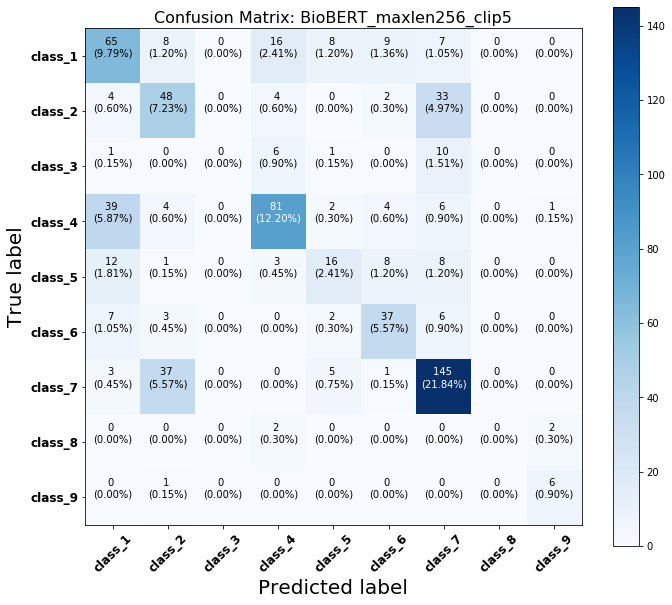

In [149]:
cm = confusion_matrix(pred_df.true_label, pred_df.prediction)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix: BioBERT_maxlen256_clip5', cmap=plt.cm.Blues)

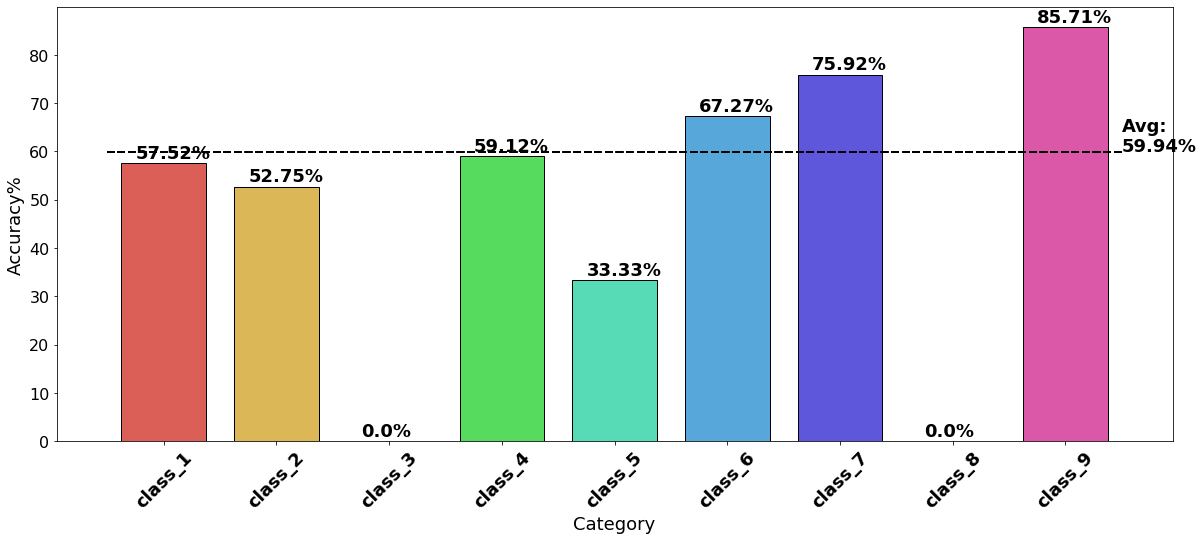

In [150]:
plot_acc_bar(cm,total_acc=59.940)

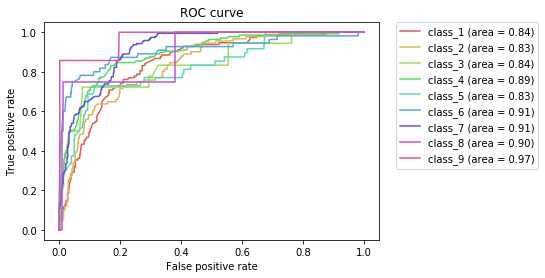

In [151]:
plot_ROC_curve(pred_df)

<a id='Part4.5.5_link'></a>
### 4.5.5 BioBERT model_5: maxlen512_clip1

In [156]:
model = BertForSequenceClassification.from_pretrained(os.path.join(base_dir,'models_bert/Personalized_Medicine_biobert_maxlen512_epoch10_batch8_step80_clip1'),num_labels=9)


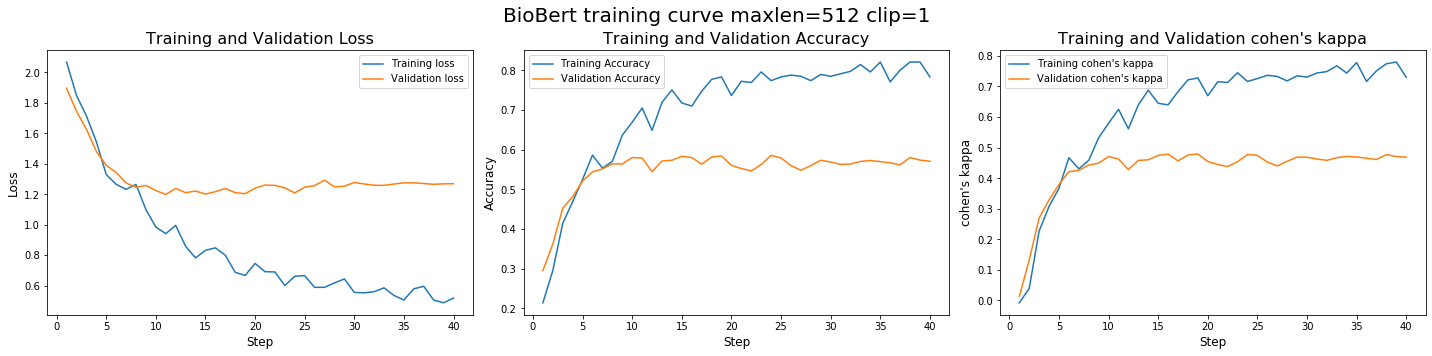

In [157]:
step_df_maxlen512_clip1=pd.read_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen512_epoch10_batch8_step80_clip1.csv"))
plot_training_validation_curve(step_df_maxlen128_clip1,title="BioBert training curve maxlen=512 clip=1")

In [158]:
classes = np.array(['Class_'+str(i+1) for i in np.arange(9)])
summary_df,pred_df=bert_eval(val_loader, model, device, classes)

Test Loss: 1.166820

Test Accuracy (Overall): 58.886%  (391.0/664.0)

Test Accuracy of Class_1: 44.248% (50.0/113.0)
Test Accuracy of Class_2: 29.670% (27.0/91.0)
Test Accuracy of Class_3: 5.556% (1.0/18.0)
Test Accuracy of Class_4: 70.803% (97.0/137.0)
Test Accuracy of Class_5: 37.500% (18.0/48.0)
Test Accuracy of Class_6: 67.273% (37.0/55.0)
Test Accuracy of Class_7: 82.723% (158.0/191.0)
Test Accuracy of Class_8: 0.000% (0.0/4.0)
Test Accuracy of Class_9: 42.857% (3.0/7.0)


In [159]:
summary_df.to_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen512_epoch10_batch8_step80_clip1_summary_df.csv"),index=False)
pred_df.to_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen512_epoch10_batch8_step80_clip1_pred_df.csv"),index=False)

#summary_df=pd.read_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen512_epoch10_batch8_step80_clip1_summary_df.csv"))
#pred_df=pd.read_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen512_epoch10_batch8_step80_clip1_pred_df.csv"))


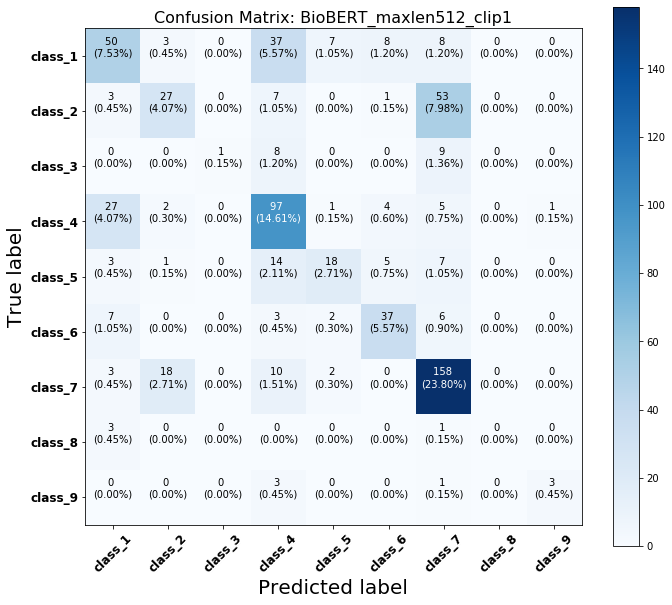

In [160]:
cm = confusion_matrix(pred_df.true_label, pred_df.prediction)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix: BioBERT_maxlen512_clip1', cmap=plt.cm.Blues)

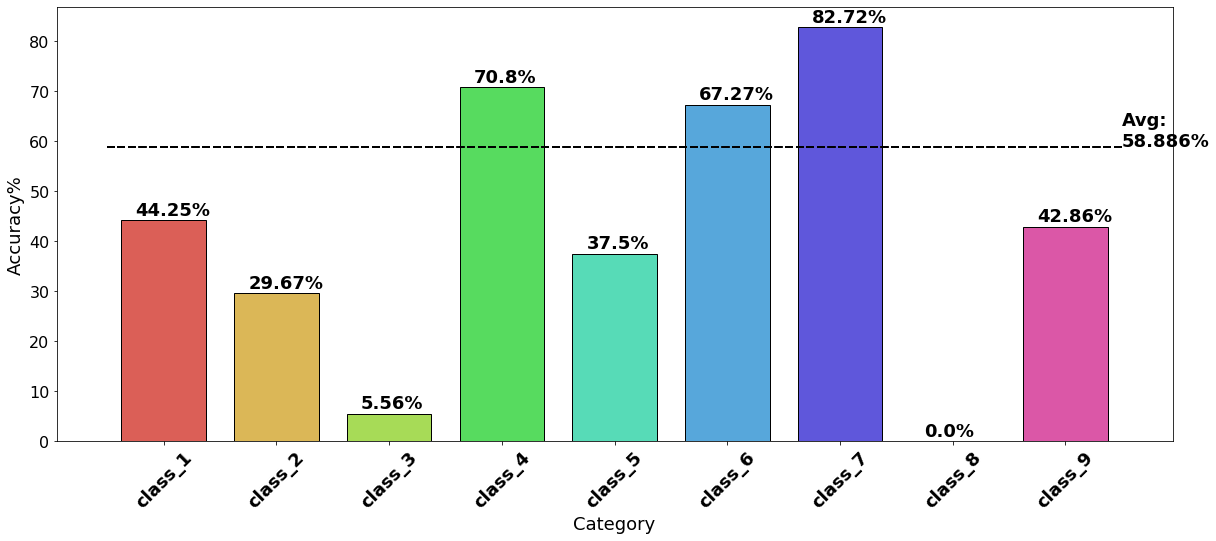

In [161]:
plot_acc_bar(cm,total_acc=58.886)

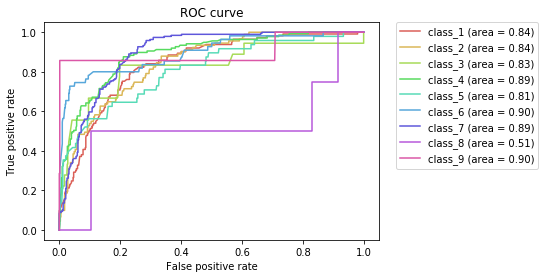

In [162]:
plot_ROC_curve(pred_df)

<a id='Part4.5.6_link'></a>
### 4.5.6 BioBERT model_6: maxlen512_clip5

In [164]:
model = BertForSequenceClassification.from_pretrained(os.path.join(base_dir,'models_bert/Personalized_Medicine_biobert_maxlen512_epoch10_batch8_step80_clip5'),num_labels=9)


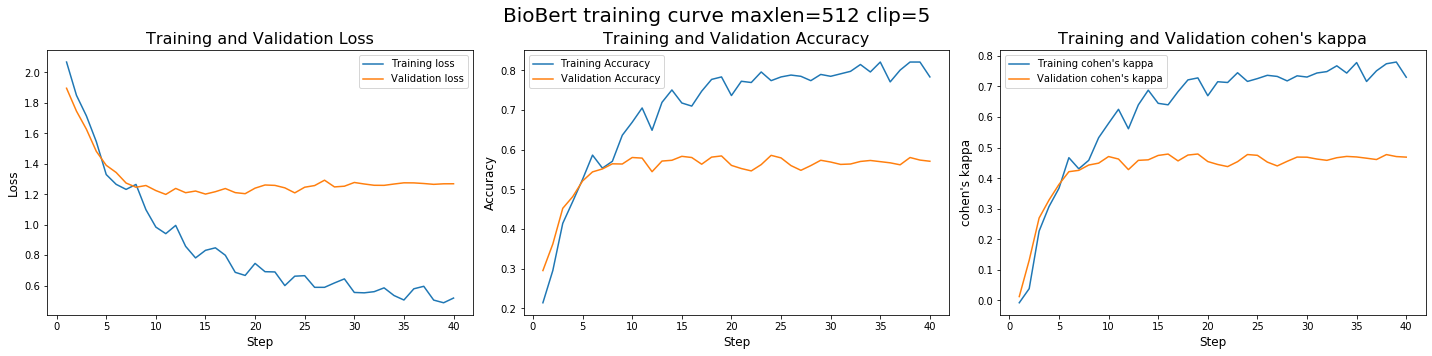

In [165]:
step_df_maxlen512_clip5=pd.read_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen512_epoch10_batch8_step80_clip5.csv"))
plot_training_validation_curve(step_df_maxlen128_clip1,title="BioBert training curve maxlen=512 clip=5")

In [166]:
classes = np.array(['Class_'+str(i+1) for i in np.arange(9)])
summary_df,pred_df=bert_eval(val_loader, model, device, classes)

Test Loss: 1.166939

Test Accuracy (Overall): 59.036%  (392.0/664.0)

Test Accuracy of Class_1: 48.673% (55.0/113.0)
Test Accuracy of Class_2: 39.560% (36.0/91.0)
Test Accuracy of Class_3: 11.111% (2.0/18.0)
Test Accuracy of Class_4: 67.883% (93.0/137.0)
Test Accuracy of Class_5: 37.500% (18.0/48.0)
Test Accuracy of Class_6: 65.455% (36.0/55.0)
Test Accuracy of Class_7: 76.440% (146.0/191.0)
Test Accuracy of Class_8: 0.000% (0.0/4.0)
Test Accuracy of Class_9: 85.714% (6.0/7.0)


In [167]:
summary_df.to_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen512_epoch10_batch8_step80_clip5_summary_df.csv"),index=False)
pred_df.to_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen512_epoch10_batch8_step80_clip5_pred_df.csv"),index=False)

#summary_df=pd.read_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen512_epoch10_batch8_step80_clip5_summary_df.csv"))
#pred_df=pd.read_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen512_epoch10_batch8_step80_clip5_pred_df.csv"))


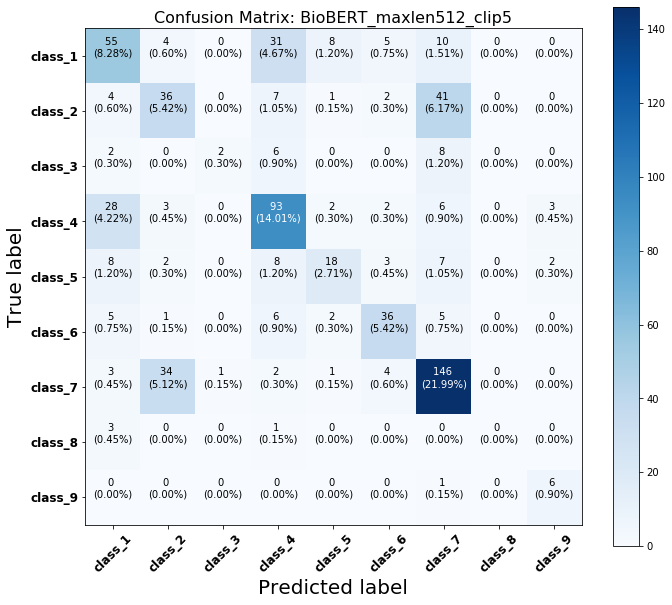

In [168]:
cm = confusion_matrix(pred_df.true_label, pred_df.prediction)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix: BioBERT_maxlen512_clip5', cmap=plt.cm.Blues)

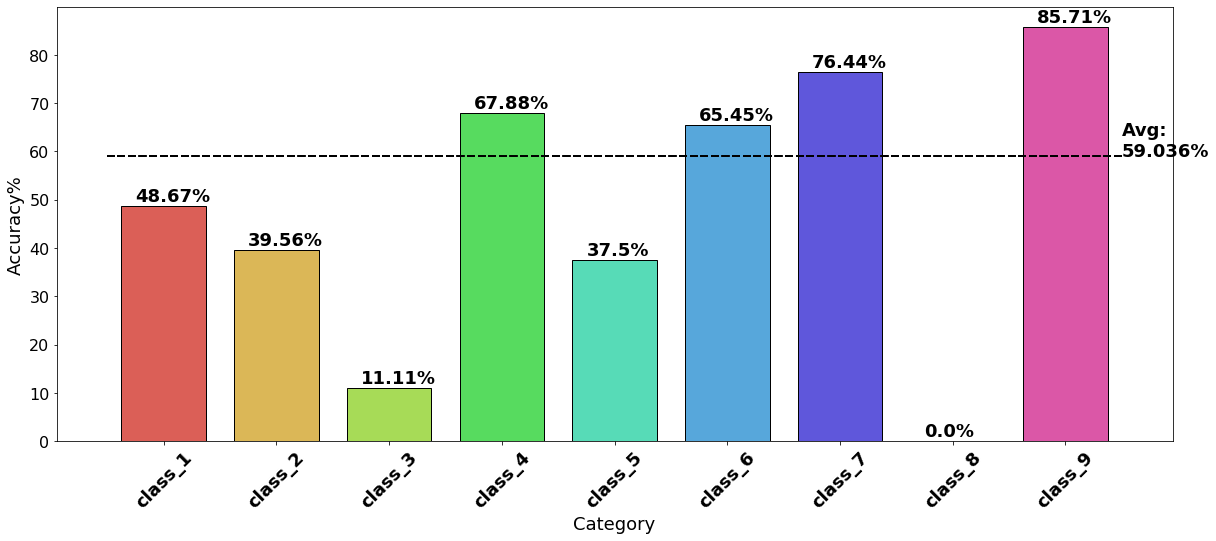

In [169]:
plot_acc_bar(cm,total_acc=59.036)

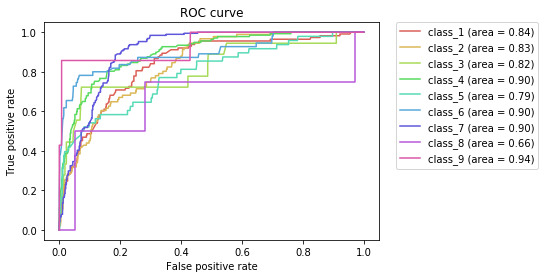

In [170]:
plot_ROC_curve(pred_df)

<a id='Part4.6_link'></a>
## 4.6 Make prediction

<a id='Part4.6.1_link'></a>
### 4.6.1 BioBERT model_1: maxlen128_clip1 prediction

In [ ]:
model = BertForSequenceClassification.from_pretrained(os.path.join(base_dir,'models_bert/Personalized_Medicine_biobert_maxlen128_epoch10_batch32_step20_clip1'),num_labels=9)


In [96]:
classes = np.array(['Class_'+str(i+1) for i in np.arange(9)])
test_pred_maxlen128_clip1_df=bert_test(test_loader, model, device, classes)

In [97]:
test_pred_maxlen128_clip1_df.head()

,prediction,prob,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9
0,6,4.168688,-1.513914,1.703681,-0.485511,-1.728868,-0.303762,-0.811062,4.168688,-1.303748,-1.357913
1,3,3.273376,2.615129,-0.717567,-0.733339,3.273376,-0.707571,-0.299178,-1.683335,-1.221446,-1.124954
2,6,2.634990,-0.748409,1.403695,-0.711848,-2.083047,0.185040,0.517661,2.634990,-1.693114,-1.767329
3,6,3.247443,-1.127982,2.983355,-0.920976,-1.464768,-1.229303,-0.814714,3.247443,-1.263216,-2.064109
4,0,3.117141,3.117141,-0.458939,-0.995592,1.633769,-0.074026,0.606578,-1.854727,-1.440363,-1.214468


In [98]:
test_pred_maxlen128_clip1_df.to_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen128_epoch10_batch32_step20_clip1_test_df.csv"),index=False)


<a id='Part4.6.2_link'></a>
### 4.6.2 BioBERT model_2: maxlen128_clip5 prediction

In [ ]:
model = BertForSequenceClassification.from_pretrained(os.path.join(base_dir,'models_bert/Personalized_Medicine_biobert_maxlen128_epoch10_batch32_step20_clip5'),num_labels=9)


In [109]:
classes = np.array(['Class_'+str(i+1) for i in np.arange(9)])
test_pred_maxlen128_clip5_df=bert_test(test_loader, model, device, classes)

In [110]:
test_pred_maxlen128_clip5_df.head()

,prediction,prob,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9
0,6,3.635192,-1.371319,1.395744,0.048646,-0.756559,-0.474636,-0.354585,3.635192,-0.980288,-1.400234
1,3,2.401799,2.297631,-0.652247,-1.122568,2.401799,-0.379395,-0.147556,-1.058156,-1.369553,-0.768239
2,6,2.124892,0.055637,0.838953,-0.556182,-0.579507,0.750434,0.719332,2.124892,-1.518587,-1.512856
3,1,3.150675,-1.335871,3.150675,-0.472835,-1.706151,-0.273013,0.240842,2.868222,-0.988771,-1.455853
4,1,1.912388,0.448757,1.912388,-1.148854,-0.147773,-0.254603,0.743807,1.333780,-1.764599,-1.712613


In [111]:
test_pred_maxlen128_clip5_df.to_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen128_epoch10_batch32_step20_clip5_test_df.csv"),index=False)


<a id='Part4.6.3_link'></a>
### 4.6.3 BioBERT model_3: maxlen256_clip1 prediction

In [ ]:
model = BertForSequenceClassification.from_pretrained(os.path.join(base_dir,'models_bert/Personalized_Medicine_biobert_maxlen256_epoch10_batch16_step40_clip1'),num_labels=9)


In [ ]:
classes = np.array(['Class_'+str(i+1) for i in np.arange(9)])
test_pred_maxlen256_clip1_df=bert_test(test_loader, model, device, classes)

In [22]:
test_pred_maxlen256_clip1_df.head()

,prediction,prob,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9
0,6,3.498889,-1.134195,0.743998,-0.326424,-0.841339,-0.251164,-1.043671,3.498889,-1.303027,-1.330953
1,3,3.363237,1.589929,-0.580673,-0.824652,3.363237,-0.408460,0.324055,-1.277519,-1.820925,-1.254736
2,6,3.048277,-0.832828,2.827604,-1.127817,-1.443068,-0.409872,0.056793,3.048277,-1.894315,-1.531090
3,6,3.541371,-1.853958,3.215243,-0.992977,-1.991859,-0.362577,-0.019087,3.541371,-1.183939,-1.207360
4,0,2.573332,2.573332,-0.170585,-0.758375,2.012901,-0.412117,-0.540525,-1.228941,-1.755108,-1.835769


In [17]:
#test_pred_maxlen256_clip1_df.to_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen256_epoch10_batch16_step40_clip1_test_df.csv"),index=False)
test_pred_maxlen256_clip1_df=pd.read_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen256_epoch10_batch16_step40_clip1_test_df.csv"))

<a id='Part4.6.4_link'></a>
### 4.6.4 BioBERT model_4: maxlen256_clip5 prediction

In [ ]:
model = BertForSequenceClassification.from_pretrained(os.path.join(base_dir,'models_bert/Personalized_Medicine_biobert_maxlen256_epoch10_batch16_step40_clip5'),num_labels=9)


In [ ]:
classes = np.array(['Class_'+str(i+1) for i in np.arange(9)])
test_pred_df=bert_test(test_loader, model, device, classes)

In [24]:
test_pred_maxlen256_clip5_df.head()

,prediction,prob,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9
0,6,4.524332,-1.489478,1.138975,-0.419258,-1.434450,-0.130485,-0.734630,4.524332,-1.307086,-1.759578
1,3,3.830017,2.967546,-0.932506,-0.254982,3.830017,-0.732073,-0.552600,-1.368752,-1.646218,-1.346592
2,6,1.625742,0.133845,0.224316,-0.615509,-0.636209,0.652265,0.690071,1.625742,-2.057551,-2.110268
3,1,3.694615,-1.981358,3.694615,-1.277137,-2.036504,-0.543049,0.113569,3.407263,-1.109834,-1.245273
4,0,3.027819,3.027819,-0.721729,-0.568941,2.219147,-0.158788,0.440849,-1.425194,-2.035869,-1.631032


In [23]:
#test_pred_maxlen256_clip5_df.to_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen256_epoch10_batch16_step40_clip5_test_df.csv"),index=False)
test_pred_maxlen256_clip5_df=pd.read_csv(os.path.join(base_dir,"models_bert/Personalized_Medicine_biobert_maxlen256_epoch10_batch16_step40_clip5_test_df.csv"))

## Conclusion for BioBERT

<br>With pre-trained BioBERT model, 3 different max_len values have been tested for this project and the overall training performance is better than machine learning models but not as good as LSTM. The highest accuracy achieved by the trained BioBERT model is 0.5994. In addition, training only 2 epochs can achieve the optimal accuracy, which is significantly faster than the LSTM models.